<a href="https://colab.research.google.com/github/AvilashaHaldar/Monte_Carlo_Exercises/blob/main/Monte_Carlo_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

# **Monte Carlo Examples**

Hello, and welcome! In this notebook, I'm going to share some examples of how we can use the Monte Carlo methodology of simulating a situation many times to arrive at the true answer. Let's start with a Gambler's Ruin problem.

## **Problem 1: Gambler's Ruin (Simple)**

I am playing a game with a friend where we each start off with 0 points. Each round, we place a stone in the middle between us and see who can grab the stone first. Whoever grabs the stone first wins that round. Whoever gets a 5 point lead over the other person first wins the game.

Say my friend has a faster reaction speed than me, so they have a 55% chance of grabbing the stone first each round. What are their chances of winning the whole game?

### **How to Solve Analytically**

This is a problem which *can* be solved analytically by modelling the game as a Markov chain with states $n = -5$ to $n - 5$. Because we are specifically being asked about the chance of winning a certain amount (5 rounds) before being ruined (losing 5 rounds), we can use the Gambler's Ruin formula as follows:

$$P_{\text{friend wins}} = \frac{1 - (\frac{q}{p})^a}{1 - (\frac{q}{p})^{a+b}}$$

where $p =$ the chance of our friend winning a round $(=0.55)$, $q = 1-p = 0.45$, $a=$ the amount we need to lose to face ruin $(=5)$, and $b=$ the amount we need to win to win the whole game $(=5)$. This gives us:

$$P_{\text{friend wins}} = \frac{1 - (\frac{0.45}{0.55})^5}{1 - (\frac{0.45}{0.55})^{10}} = 73.172\%$$

### **How to Solve Algorithmically**

Let's now see if we get the same result simply by simulating playing the game many times. We'll write a function to represent playing the game repeatedly and seeing what the probability of the friend winning tends to as we increase the number of game simulations.

For each game, we'll allow `n_rounds_per_game = 1e5`, just to make sure we don't get stuck in an infinite loop by some bad stroke of luck, which does mean we're making a simplification which renders our code slightly inaccurate to reality. Realistically, we'd never expect a single game to take this many rounds, but having the break condition in a while loop is always good for peace of mind.

For each game, if someone wins, we'll add 1 to the win counter for the appropriate player. If `n_rounds_per_game` have passed and no one's won, we'll quit the while loop for that game and move on to the next game. We'll do this `n_games` times and print out the probability of our friend winning as determined by the results so far. We'll also plot the value given by the Gambler's Ruin formula. Let's go!

*Note: The program takes a minute or so for* `n_games = 1e6`, *and multiple minutes for* `n_games = 1e7`. *Please give it a little time!*

In [17]:
def gamblers_ruin_formula(p_win: float, amount_to_lose: int, amount_to_win: int) -> float:
  """
  Determines the chances of me winning the game based on my chances of winning a round, and the amount I need to lose and win. Assumes that the chance of winning one round is constant.
  """
  if p_win < 0 or p_win > 1:
    raise ValueError(f"p_win must be between 0 and 1. Value given is {p_win}.")

  amount_to_win = abs(amount_to_win)
  amount_to_lose = abs(amount_to_lose)
  q_lose = 1 - p_win

  return (1 - (q_lose/p_win)**amount_to_lose) / (1 - (q_lose/p_win)**(amount_to_lose + amount_to_win))

def stones_game_Monte_Carlo(p_win_after_loss: float = 0.55,
                                    p_win_after_win: float = 0.48,
                                    stones_to_lose: int = 5,
                                    stones_to_win: int = 5,
                                    n_games: int = 1000,
                                    n_rounds_per_game: int = 1000) -> np.array:
  """
  Returns the proportion of times that someone wins in a Gambler's Ruin situation, which as n_games increases, will tend towards the true probability of our friend winning a game.
  """

  # Checking inputs
  n_games = int(n_games)
  n_rounds_per_game = int(n_rounds_per_game)

  if p_win_after_loss < 0 or p_win_after_loss > 1:
    raise ValueError(f"p_win_after_loss must be between 0 and 1. Value given is {p_win_after_loss}.")
  if p_win_after_win < 0 or p_win_after_win > 1:
    raise ValueError(f"p_win_after_win must be between 0 and 1. Value given is {p_win_after_win}.")
  if n_games < 1:
    raise ValueError(f"n_games must be at least 1. Value given is {n_games}.")
  if n_rounds_per_game < 1:
    raise ValueError(f"n_rounds_per_game must be at least 1. Value given is {n_rounds_per_game}.")

  # Setting starting values
  wins = 0
  losses = 0
  proportion_wins = np.zeros(n_games)

  for games_done in range(n_games):
    rounds_done = 0
    score = 0
    won_last_round = False

    while (rounds_done <= n_rounds_per_game) and (score < stones_to_win) and (score > -stones_to_lose):
      if won_last_round:
        if np.random.rand() < p_win_after_win:
          score += 1
          won_last_round = True
        else:
          score -= 1
          won_last_round = False
      else:
        if np.random.rand() < p_win_after_loss:
          score += 1
          won_last_round = True
        else:
          score -= 1
          won_last_round = False

      if score == stones_to_win:
        wins += 1
      if score == -stones_to_lose:
        losses += 1

      rounds_done += 1

    proportion_wins[games_done] = (wins / (wins + losses))
  return proportion_wins

def plot_Monte_Carlo(proportion_wins: np.array, p_win_round = 0.5, stones_to_win: int = 5, stones_to_lose: int = 5, plot_gamblers_ruin_formula: bool=False):
  n_games = len(proportion_wins)

  if plot_gamblers_ruin_formula:
    gamblers_ruin_formula_answer = gamblers_ruin_formula(p_win_round, stones_to_lose, stones_to_win)
    plt.plot([0, n_games-1], [gamblers_ruin_formula_answer, gamblers_ruin_formula_answer], label = f"Gambler's Ruin Formula: Final value {round(gamblers_ruin_formula_answer,4)}")

  plt.plot(range(0, n_games), proportion_wins, label = f"Monte Carlo: Final value {round(proportion_wins[-1], 4)}")

  plt.xlabel("Number of Games")
  plt.ylabel("Proportion of Times Friend Wins")
  if plot_gamblers_ruin_formula:
    plt.title(f"Proportion of Friend's Wins (p_win = {p_win_round})")
  else:
    plt.title(f"Proportion of Friend's Wins")
  plt.ylim(0, 1)
  plt.xscale('log')

  plt.legend()
  plt.show()

In [18]:
p_win_round = 0.55
stones_to_lose = 5
stones_to_win = 5
n_games = int(1e6)

proportion_wins = stones_game_Monte_Carlo(p_win_after_loss = p_win_round,
                                          p_win_after_win = p_win_round,
                                          stones_to_lose = stones_to_lose,
                                          stones_to_win = stones_to_win,
                                          n_games = n_games)

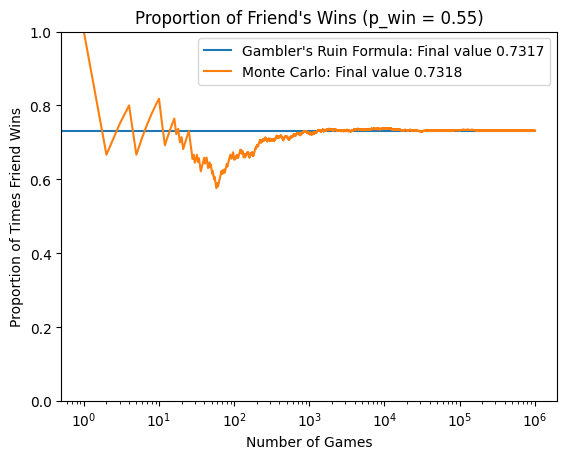

In [19]:
plot_Monte_Carlo(proportion_wins, p_win_round, stones_to_win, stones_to_lose, True)

We can see that despite the simplification we made by including a limit on the possible number of rounds, our percentage does get quite close to the true value after a while, with diminishing returns on improvement as the number of games increases. Note the logarithmic scale along the bottom.

## **Problem 2: Gambler's Ruin (complex)**

Now, let's go for a challenge. Say that the probability of our friend winning each round doesn't stay constant over time. Say that if he've just lost the previous round, his chances of winning a round remain $0.55$, but if he's just won a round, he gets a bit cocky and becomes slow, reducing his probability of winning the round to just $0.48$. This would be a non-constant Markov chain and significantly more annoying to solve analytically, since we'd also need to consider a time dependency matrix.

You may have already noticed that the function `stones_game_Monte_Carlo` contains the arguments `p_win_after_win` and `p_win_after_loss`, which we set to the same value previously. Now, we're going to make those values different. Let's see what our friend's probability of winning looks like in this situation, minding that there's no Gambler's Ruin formula to compare to, since the Gambler's Ruin formula assumes independence of rounds:

In [20]:
p_win_after_loss = 0.55
p_win_after_win = 0.48
stones_to_lose = 5
stones_to_win = 5
n_games = int(1e6)

proportion_wins = stones_game_Monte_Carlo(p_win_after_loss = p_win_after_loss,
                                          p_win_after_win = p_win_after_win,
                                          stones_to_lose = stones_to_lose,
                                          stones_to_win = stones_to_win,
                                          n_games = n_games)

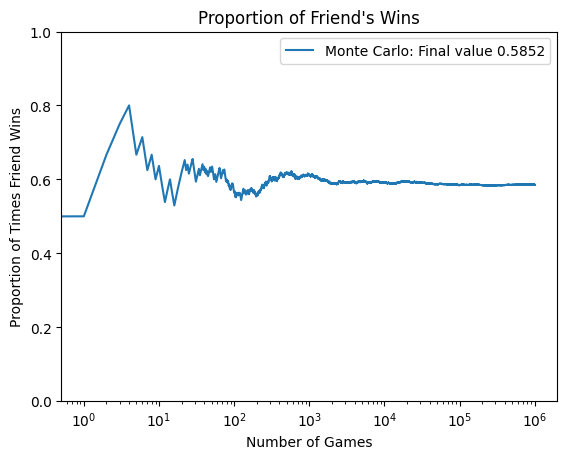

In [21]:
plot_Monte_Carlo(proportion_wins, plot_gamblers_ruin_formula=False)

It appears that our friend's overconfidence has evened the odds a fair bit, although not completely. Now let's look at a problem that can't (as far as I know) be solved analytically (although I'm happy to be proven wrong!).

## **Problem 3: Many-Playered Game**

The mechanics are the same as before, but now there are many of us (let's say 3 people) sitting in a circle, and whoever grabs the stone first wins that round. Whoever gets a 2 point lead overall all other players wins the game. Each person's reaction speed is given by a lognormal distribution with a unique mean and standard deviation. What is each player's chance of winning the entire game?

This is not a situation which cannot easily be modelled analytically, but can definitely be modelled algorithmically. Let's see what that would look like:

In [72]:
def many_playered_game_Monte_Carlo(means: np.array, stdevs: np.array, lead_to_win: int = 2, n_games: int = 100, n_rounds_per_game: int = 100) -> np.array:
  """
  Returns the proportion of times that someone wins in a many-playered game, which as n_games increases, will tend towards the true probabilities.
  """

  n_games = int(n_games)
  n_rounds_per_game = int(n_rounds_per_game)

  if n_games < 1:
    raise ValueError(f"n_games must be at least 1. Value given is {n_games}.")
  if n_rounds_per_game < 1:
    raise ValueError(f"n_rounds_per_game must be at least 1. Value given is {n_rounds_per_game}.")

  if (means <= 0).any() or (stdevs <= 0).any():
    raise ValueError("Means and standard deviations must be positive.")
  if len(means) != len(stdevs):
    raise ValueError("Means and standard deviations must have the same length.")

  num_players = len(means)
  wins = np.zeros(num_players)
  proportion_wins = np.zeros((num_players, n_games))

  for games_done in range(n_games):
    rounds_done = 0
    scores = np.zeros(num_players)
    player_distribs = np.zeros((num_players, n_rounds_per_game))

    for player in range(num_players):
      player_distrib = np.random.lognormal(mean=means[player], sigma=stdevs[player], size=(1, n_rounds_per_game))
      player_distribs[player] = player_distrib
    round_winner = np.argmin(player_distribs, axis=0)

    while (rounds_done < n_rounds_per_game):
      player_winning_this_round = round_winner[rounds_done]
      scores[player_winning_this_round] += 1
      rounds_done += 1

      if np.diff(np.sort(scores))[-1] >= lead_to_win:
        wins[player_winning_this_round] += 1
        break

    proportion_wins[:, games_done] = wins / np.sum(wins)

  return proportion_wins

def plot_Monte_Carlo_many_players(proportion_wins: np.array):
  for player in range(len(proportion_wins)):
    plt.plot(range(int(n_games)), proportion_wins[player], label=f"Player {player}")
  plt.xlabel("Number of Games")
  plt.ylabel("Proportion of Times Player Wins")
  plt.title(f"Proportion of Player's Wins")
  plt.ylim(0, 1)
  plt.legend()
  plt.plot()

In [76]:
means = np.array([1.3, 0.9, 0.7])
stdevs = np.array([1.2, 0.6, 0.2])
lead_to_win = 2
n_games = 1e3
n_rounds_per_game = int(1e5)

proportion_wins = many_playered_game_Monte_Carlo(means, stdevs, lead_to_win, n_games, n_rounds_per_game)

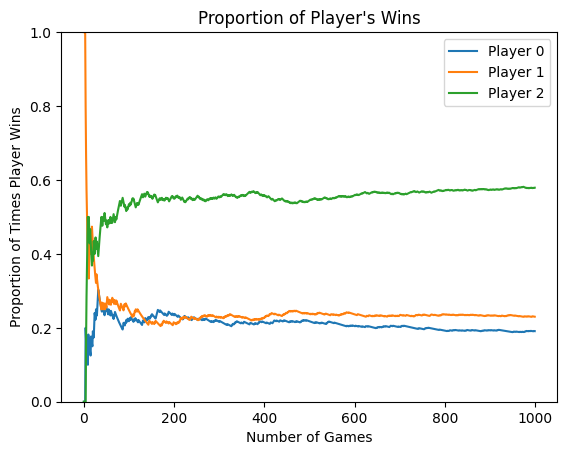

In [77]:
plot_Monte_Carlo_many_players(proportion_wins)

Please note that this variation of the stones game processes extremely slowly, despite my attempt to vectorize the determination of who wins each round. I've set `n_games` very low, so the graph won't actually show the expected true value, but it should be enough to illustrate the point that for situations which can't be determined analytically, we can use the Monte Carlo method to simulate the situation many times and figure out what the expected value would be that way.